# 基于批量归一化的 LeNet 在 FashionMNIST 数据集的分类
## 批量归一化
主要功能：一般使用在全连接层或卷积层后，激活函数前。通过固定批量的均值与方差，允许使用较大的学习率，从而加速网络收敛

### 手动实现

In [1]:
# imports
import torch
from torch import nn 
from torch import optim
import basic as b

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0,2,3),keepdim=True)
            var = ((X-mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X-mean)/torch.sqrt(var+eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum*moving_mean + (1.0-momentum) * mean
        moving_var = momentum*moving_var + (1.0-momentum) * var
    y = gamma * X_hat + beta # 缩放和移位
    return y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
        self.moving_mean,self.moving_var,eps=1e-6,momentum=0.9)
        return y

class LeNet1(b.Net):
    def __init__(self):
        super(b.Net).__init__()
        self.lenet()
    
    def lenet(self):
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            BatchNorm(6,num_dims=4),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(6,16,kernel_size=5),
            BatchNorm(16,num_dims=4),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.Linear(16*5*5, 120),
            BatchNorm(120,num_dims=2),
            nn.Sigmoid(),
            nn.Linear(120,84),
            BatchNorm(84,num_dims=2),
            nn.Sigmoid(),
            nn.Linear(84,10))  

['dress', 't-shirt', 'sneaker', 'ankle boot']


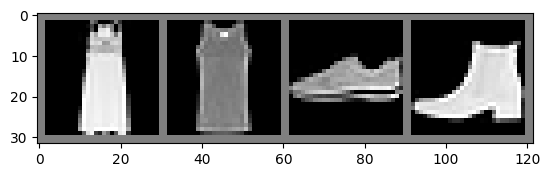

In [2]:
ROOT = "./data"
BatchSize = 128
optimizer = optim.SGD
criterion = nn.CrossEntropyLoss()

trains, tests, labels = b.load_FashionMNIST_datasets(BatchSize,28,ROOT)
b.show_some_samples(trains,labels)

In [4]:
lenet = LeNet1()
lenet.train(trains,criterion,optimizer,epochs=10,lr=1.0)

Training on!


 10%|█         | 1/10 [00:12<01:50, 12.27s/it]

epoch 1, avg_loss: 0.6380412388179038


 20%|██        | 2/10 [00:22<01:30, 11.32s/it]

epoch 2, avg_loss: 0.38358500370612514


 30%|███       | 3/10 [00:33<01:17, 11.14s/it]

epoch 3, avg_loss: 0.3407077285596448


 40%|████      | 4/10 [00:44<01:05, 10.96s/it]

epoch 4, avg_loss: 0.31016996604764563


 50%|█████     | 5/10 [00:55<00:54, 10.90s/it]

epoch 5, avg_loss: 0.2968189941607734


 60%|██████    | 6/10 [01:05<00:43, 10.79s/it]

epoch 6, avg_loss: 0.2792499763970701


 70%|███████   | 7/10 [01:16<00:32, 10.76s/it]

epoch 7, avg_loss: 0.27450389465969854


 80%|████████  | 8/10 [01:27<00:21, 10.78s/it]

epoch 8, avg_loss: 0.2648674126746308


 90%|█████████ | 9/10 [01:38<00:10, 10.78s/it]

epoch 9, avg_loss: 0.25443389187129134


100%|██████████| 10/10 [01:48<00:00, 10.88s/it]

epoch 10, avg_loss: 0.24702637371981245
Finish Training!


In [5]:
lenet.accuracy(tests)
lenet.label_accuracy(tests,labels)

Total Accuracy:  88.87
Accuracy of t-shirt : 86 %
Accuracy of trouser : 96 %
Accuracy of pullover : 82 %
Accuracy of dress : 93 %
Accuracy of  coat : 81 %
Accuracy of sandal : 97 %
Accuracy of shirt : 61 %
Accuracy of sneaker : 96 %
Accuracy of   bag : 97 %
Accuracy of ankle boot : 95 %


### 快速实现批量归一化

In [ ]:
class LeNet2(b.Net):
    def __init__(self):
        super(b.Net).__init__()
        self.lenet()
    
    def lenet(self):
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Conv2d(6,16,kernel_size=5),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2,stride=2),
            nn.Flatten(),
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),
            nn.Sigmoid(),
            nn.Linear(84,10))  